# Computerphysik Programmiertutorial 6
Prof. Dr. Matteo Rizzi und Dr. Markus Schmitt - Institut für Theoretische Physik, Universität zu Köln
&nbsp;


**Github**: [https://github.com/markusschmitt/compphys2022](https://github.com/markusschmitt/compphys2022)

**Inhalt dieses Notebooks**: Rechnungen geschickt sortieren, Arithmetische Intensität


## Rechnungen geschickt sortieren

Die Rechenzeit verschiedener mathematisch identischer Operationen kann sehr unterschiedlich sein. Ein Beispiel ist die Multiplikation von drei oder mehr Matrizen.

Sehen wir uns das Produkt der Matrizen A (Größe $p_1\times p_2$), B (Größe $p_2\times p_3$) und C (Größe $p_3\times p_4$) an:

In [1]:
using BenchmarkTools

# Abschalten der automatischen Parallelisierung von Julia
using LinearAlgebra
BLAS.set_num_threads(1);

p=[70,99,123,4]

A=rand(p[1],p[2])
B=rand(p[2],p[3])
C=rand(p[3],p[4]);

Messe die Zeit um das Produkt $A\cdot B\cdot C$ zu berechnen:

In [2]:
@belapsed A*B*C

7.302e-6

Da Matrixmultiplikation assoziativ ist, gilt mathematisch

$$A\cdot B\cdot C = A\cdot (B\cdot C)$$

Timing von $A\cdot (B\cdot C)$:

In [3]:
@belapsed A*(B*C)

7.3125e-6

Timing von $(A\cdot B)\cdot C$:

In [4]:
@belapsed (A*B)*C

4.6292e-5

Wie viele Rechenoperationen werden jeweils durchgeführt? Multiplizieren einer $p\times q$-Matrix mit einer $q\times r$-Matrix braucht $pqr$ Rechenoperationen.

* $(A\cdot B)\cdot C$ kostet $p_1 p_2 p_3 + p_1p_3p_4$ Rechenoperationen
* $A\cdot (B\cdot C)$ kostet $p_2 p_3 p_4 + p_1p_2p_4$ Rechenoperationen

In [5]:
cost_ab_c(p) = p[1]*p[2]*p[3] + p[1]*p[3]*p[4]
cost_a_bc(p) = p[2]*p[3]*p[4] + p[1]*p[2]*p[4]

cost_a_bc (generic function with 1 method)

Anzahl Rechenoperationen für $(A\cdot B)\cdot C$:

In [6]:
cost_ab_c(p)

886830

Anzahl Rechenoperationen für $A\cdot (B\cdot C)$:

In [7]:
cost_a_bc(p)

76428

**Ergebnis:** Der Faktor 10 im Laufzeitunterschied entspricht in etwa dem Unterschied in der Zahl an Rechenoperationen

## Arithmetische Intensität

Neben den eigentlichen Rechnungen können auch Speicherzugriffe die Operation sein, die den Preis einer Rechnung bestimmen. Das Lesen und Schreiben von Daten im Speicher ist generell teuer. Diese Operationen sind *mindestens* $10\times$ langsamer als eine Fließkommarechnung.

Die Geschwindigkeit einer Rechnung kann also generell entweder durch die Frequenz elementarer Rechenoperationen (*compute-bound*) oder durch die maximale Geschwindigkeit von Speicherzugriffen (*compute-bound*) beschränkt sein. Welcher der beiden Fälle auf einen bestimmten Algorithmus zutrifft wird durch die **arithmetische Intensität** angezeigt. Die arithmetische Intensität ist definiert als die Zahl der Rechenoperationen pro Menge der gelesenen/geschriebenen Daten:

$$I_A=\frac{\text{# Rechenoperationen}}{\text{# gelesene/geschriebene Daten}} \text{ [1/Byte]}$$

* Eine hohe arithmetische Intensität bedeutet, dass viele Rechnungen pro Speicherzugriff ausgeführt werden - der Algorithmus ist daher *compute-bound*.

* Eine niedrige arithmetische Intensität bedeutet, dass viele Speicherzugriffe pro Rechnung ausgeführt werden - der Algorithmus ist daher *memory-bound*.

### Beispiel: Matrix-Matrix Multiplikation

Die Multiplikation einer $p\times p$-Matrix mit einer $p\times q$-Matrix kostet $2p^2q$ elementare Rechenoperationen. Gleichzeitig müssen beide Matrizen aus dem Speicher ausgelesen werden und das Ergebnis muss im Speicher abgelegt werden. Das ergibt $p^2+2pq$ Speicherzugriffe. Die arithmetische Intensität ist also

$$I_A\propto\frac{p^2q}{p^2+2pq}$$

Wir nehmen an, dass $p\gg1$. Daraus ergeben sich zwei interessante Grenzfälle, abhängig von $q$:

$$
I_A\propto
\begin{cases}
q&\text{if }q\ll p\\
p&\text{if }p\approx q
\end{cases}
$$

Wir haben also geringe arithmetische Intensität, falls $q$ klein ist, und große arithmetische Intensität, falls $p$ und $q$ ähnlich groß sind.

Im folgenden Experiment messen wir die Rechenzeit von Matrix-Matrix Multiplikationen in Abhängigkeit von $q$:

In [8]:
p=2000
qs = [2^j for j in 1:14]

A=rand(p,p)

times=[]

for q in qs
    B=rand(p,q)
    
    time=@elapsed A*B
    push!(times, time)
    println("$q $time")
end

2 0.00447075
4 0.002122125
8 0.002686375
16 0.004532083
32 0.006574625
64 0.011843291
128 0.022487166
256 0.043901125
512 0.087194375
1024 0.176905042
2048 0.351348083
4096 0.736525541
8192 1.4174205
16384 2.827125875


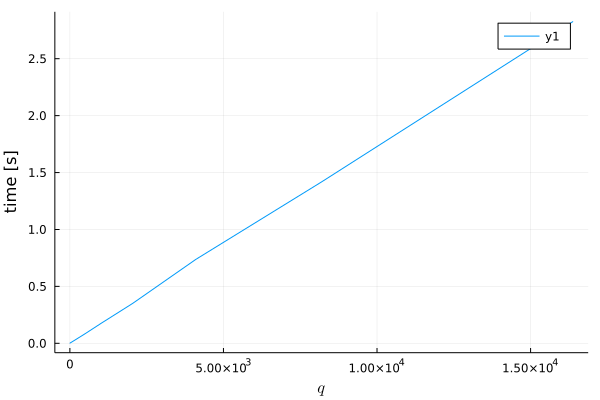

In [9]:
using Plots
using LaTeXStrings

plot(qs, times)
xlabel!(L"$q$")
ylabel!("time [s]")

Um herauszufinden wie effizient diese Rechnungen sind, können wir ausrechnen wie viele Fließkommaoperationen pro Sekunde ausgeführt werden (FLOPS):

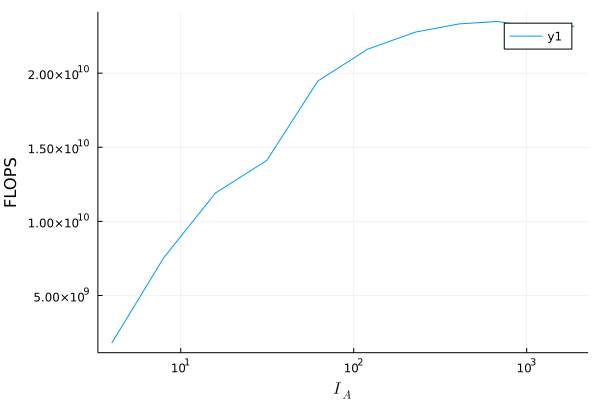

In [10]:
flops = p^2 * qs ./ times # Anzal der Fließkommaoperationen pro Sekunde

I_A(p,q) = 2p^2*q / (p^2 + 2p*q)
I = I_A.(p,qs);           # Arithmetische Intensität

plot(I, flops, xaxis=:log)
xlabel!(L"$I_A$")
ylabel!("FLOPS")

**Ergebnis:** Bei großer arithmetischer Intensität saturiert die Performance wegen der beschränkten Rechenkapazität des Computers und der Algorithmus ist *compute-bound*. Im Bereich geringer arithmetischer Intensität ist der Algorithmus *memory-bound* und kann deshalb nicht die theoretisch verfügbaren Rechenoperationen ausnutzen.